# Star Selection Function and Examples

Make the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from matplotlib.patches import Circle, Wedge, Polygon

Read in the data for the region you wish to analyse. Use the standard methods.
For this example, I will be reading in a region of the sky containing CHAMII and CHAMIII

***Update: This Notebook now uses NGC2264 as an example to test on a more complex region***

In [2]:
t = Table.read('NGC2264.vot',format='votable')
print(t.colnames) #To be able to know column names within VOTable

RA = t['RA_ICRS']
DEC = t['DE_ICRS']
Gmag = t['__Gmag_']

['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


First, we define the data that we are going to use in the Analysis.
'data' represents our RA and DEC coordinates for all stars within the region.
'redData' *(Reduced Data)* Represents all stars with Gmag Less than 17  (G <=17)

In [3]:
data = np.array([RA,DEC])
redData = []
for i in range(len(Gmag)):
    if(Gmag[i] <= 17.0):
        redData.append([RA[i],DEC[i]])
data = np.array(data)
redData = np.array(redData)
data = np.transpose(data)

The following code defines the function "distanceMap'. It will use the KDTree Nearest Neighbor algorithm to create a distance map for all of the stars in the selected region. With this distance map, it will create a contour plot to reveal the 2D structure of the cloud or clouds. It will also define a matrix called 'DistArray', and this matrix will be used for the Star Selection function. 

In [4]:
def distanceMap(N,data,k):
    Start = time.time()
    

    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),N)
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),N)
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    XY = [X,Y]
    XY = np.transpose(XY)
    XYcoords = XY[0]
    for j in range(1,len(XY)):
        XYcoords = np.vstack((XYcoords,XY[j]))

    tree = KDTree(data,50)
    dist,ind = tree.query(XYcoords,k=k)
    distArray = []
    for d in range(len(dist)):
        distArray.append(dist[d][(k-1)])   
    distArray = np.array(distArray)
    distArray = np.reshape(distArray,(-1,N))
    distArray = np.transpose(distArray)

    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    plt.contour(X,Y,distArray,8,cmap='hot')
    plt.colorbar()
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.title(str(N)+'x'+str(N)+' Contour Plot')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.gca().invert_xaxis()
    plt.show()
    End = time.time()
    print('Total Runtime: ',End-Start,'s')
    
    return distArray

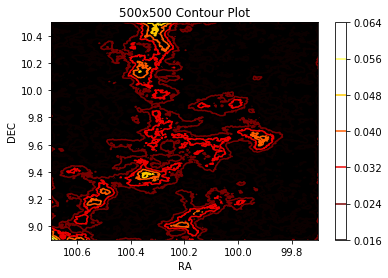

Total Runtime:  61.695202350616455 s
DistArray Defined


In [5]:
DistArray = distanceMap(500,data,20)

print('DistArray Defined')

# StarSelection_old is the older version of the function

I have made an update to the code down below




In [31]:
def StarSelection_old(distArray,RA,DEC,L,N):
    
    ## SPECIFY RA AND DEC RANGES
    RArange = RA
    DECrange = DEC
    
    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),N)
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),N)
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    cs = plt.contour(X,Y,distArray,5,alpha=1.0)
    plt.colorbar()
    plt.axvline(x=RArange,linestyle='--',color='y',alpha=0.6)
    plt.axhline(y=DECrange,linestyle='--',color='y',alpha=0.6)
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.gca().invert_xaxis()

    insideStars = []
    starCount = 0
    inside = []
    psize = 0
    for i in range(len(cs.collections[L].get_paths())):
        count = 0
        p = cs.collections[L].get_paths()[i]
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        if(RArange >= np.min(x) and RArange <= np.max(x) and DECrange >= np.min(y) and DECrange <= np.max(y)):
            count = count + 1
            polygon = v
            path = mpltPath.Path(polygon,closed=True)
            inside = path.contains_points(redData)
            coords = np.array([x,y])    
    for i in range(len(inside)):
        if(str(inside[i]) == 'True'):
            starCount = starCount + 1
            insideStars.append(redData[i])
    insideStars = np.array(insideStars)

    plt.scatter(redData[:,0],redData[:,1],s=0.7,c='orange',alpha=0.8,marker='*')
    if(len(insideStars) > 0):
        plt.scatter(insideStars[:,0],insideStars[:,1],s=2.0,c='r')
        print('Total Stars within contour: ',starCount,'\n\n')
        plt.show()
    else:
        print('No stars located within selected contour')
        plt.show()
    

# Star Selection Bug fixes/ Updates

Next, we define the function 'StarSelection' which will allow us to grab all stars located between individual contour lines. This version of the code chooses specific a specific contour at a certain level within the plot. You choose the region by simply inputting a RA and DEC. CrossHairs will appear on the plot illustrating where you are focusing your analysis. 

***Next update will remove the need to specify an RA and DEC value (Make it an optional Parameter).***

In [12]:
def StarSelection(distArray,L,RA=999,DEC=999):
    
    ## SPECIFY RA AND DEC RANGES
    RArange = RA
    DECrange = DEC
    
    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),int(np.sqrt(np.size(distArray))))
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),int(np.sqrt(np.size(distArray))))
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    cs = plt.contour(X,Y,distArray,8,alpha=0.9)
    plt.colorbar()
    plt.axvline(x=RArange,linestyle='--',color='y',alpha=0.6)
    plt.axhline(y=DECrange,linestyle='--',color='y',alpha=0.6)
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.gca().invert_xaxis()
    firstContour = []
    higherContour = []
    insideStars = []
    starCount = 0
    ## WITH A SPECIFIC RA AND DEC
    if(RA != 999 and DEC != 999):
        inside = []
        finalPoly = []
        for i in range(len(cs.collections[L].get_paths())):
            p = cs.collections[L].get_paths()[i]
            v = p.vertices
            x = v[:,0]
            y = v[:,1]
            if(RArange >= np.min(x) and RArange <= np.max(x) and DECrange >= np.min(y) and DECrange <= np.max(y)):
                polygon = v
                path = mpltPath.Path(polygon,closed=True)
                inside = path.contains_points(redData)
                finalPoly = [x,y]
                for s in range(len(inside)):
                    if(inside[s] == True):
                        firstContour.append(redData[s])
        
        finalPoly = np.transpose(np.array(finalPoly))
        inside_higher = [] 
        for j in range(len(cs.collections[L+1].get_paths())):
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            x = v[:,0]
            y = v[:,1]
            if(np.min(x)>=np.min(finalPoly[:,0]) and np.max(x)<=np.max(finalPoly[:,0]) and np.min(y)>=np.min(finalPoly[:,1]) and np.max(y)<=np.max(finalPoly[:,1])):
                polygon = v
                path2 = mpltPath.Path(polygon,closed=True)
                inside_higher = path2.contains_points(redData)
                for s in range(len(inside_higher)):
                    if(inside_higher[s] == True):
                        higherContour.append(redData[s])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour)
        #print((higherContour[0]))
        for s in range(len(firstContour)):
            if(len(higherContour > 0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])

        insideStars = np.array(insideStars)
        
    ## WITH NO SPECIFIC REGION ON CONTOUR PLOT
    else:
        firstContour = []
        higherContour = []
        inside = []
        for j in range(len(cs.collections[L].get_paths())):
                p = cs.collections[L].get_paths()[j]
                v = p.vertices
                polygon = v
                path = mpltPath.Path(polygon,closed=True)
                inside = path.contains_points(redData)
                for i in range(len(inside)):
                    if(inside[i] == True):
                        #starCount = starCount + 1
                        firstContour.append(redData[i])
        
        for j in range(len(cs.collections[L+1].get_paths())):
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            polygon = v 
            path = mpltPath.Path(polygon,closed=True)
            inside_higher = path.contains_points(redData)
            for i in range(len(inside_higher)):
                    if(inside_higher[i] == True):
                        starCount = starCount + 1
                        higherContour.append(redData[i])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour)
        for s in range(len(firstContour)):
            if(len(higherContour >0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])
        insideStars = np.array(insideStars)
    plt.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=0.4,marker='*')
    if(len(insideStars) > 0):
        plt.scatter(insideStars[:,0],insideStars[:,1],s=5.0,c='r',marker='*')
        plt.title('Map of Contour Plot with Stars Located Within Chosen Contour')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.show()
        print('Total Stars within contour: ',len(insideStars),'\n\n')
    else:
        #print('No stars located within selected contour')
        plt.show()
   
    

Now, here are examples using the Star Selection Function. 

Notice how in the first example, the higher level contour did not get mixed with the lower level contour. All of the stars within the higher contour did not get selected. This is one of the updates that I made to StarSelection

***You also do not need to specify the N value, which reduces the number of inputs required***

The first two examples demonstrate choosing two different layers of contours and specifying an RA and DEC region. Also not that the function recognizes concentric contours. This means that stars within a higher layer will not become mixed with lower level contours. 

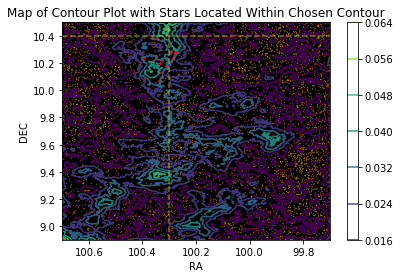

Total Stars within contour:  24 




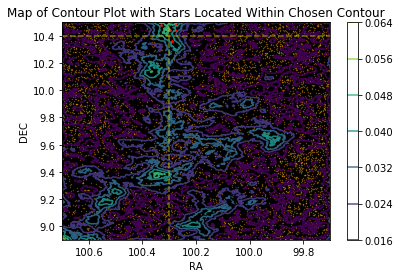

Total Stars within contour:  7 




In [9]:

StarSelection(DistArray,2,100.3,10.4)
StarSelection(DistArray,3,100.3,10.4)



The next two examples demonstrates the ability to not specify a specific contour on the plot. The only parameters you need to enter are the distance matrix 'distArray' and the contour level. Code still distinguishes between concentric contours.

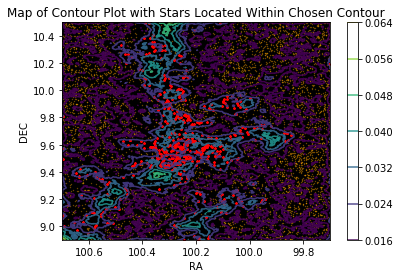

Total Stars within contour:  565 




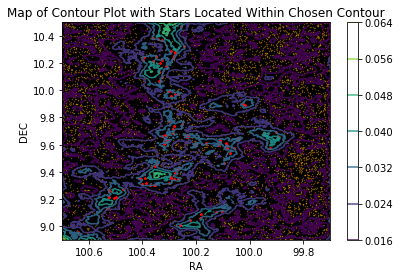

Total Stars within contour:  103 




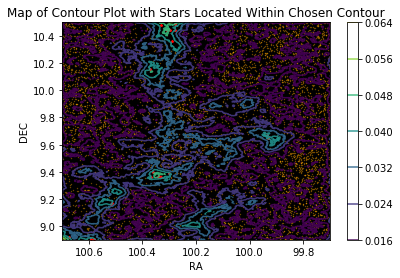

Total Stars within contour:  21 




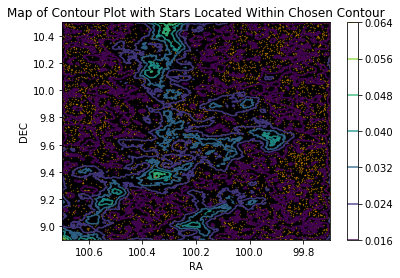

Total Stars within contour:  1 




In [13]:
StarSelection(DistArray,1)
StarSelection(DistArray,2)
StarSelection(DistArray,3)
StarSelection(DistArray,4)

Beware choosing a contour near the edge of the plot. These contours tend to not close in on themselves. When this happens, stars outside of the desired contour will also be selected. 
Here is an example:

***Example from CHAMII and CHAMIII***

Total Stars within contour:  1027 




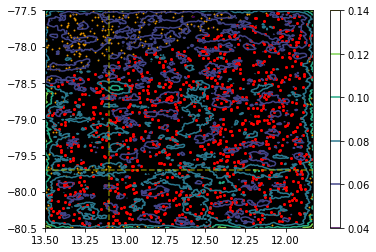

In [11]:
StarSelection(DistArray,13.10,-79.7,2,200)

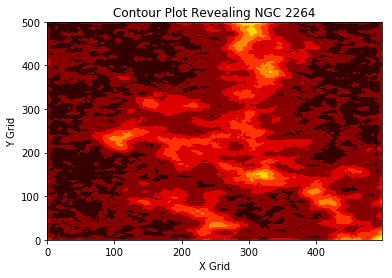

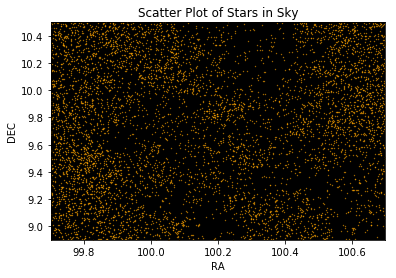

In [139]:


fig, ax = plt.subplots()
ax.set_facecolor('black')


ax.contourf(DistArray,8,cmap='hot')
plt.title('Contour Plot Revealing NGC 2264')
plt.xlabel('X Grid')
plt.ylabel('Y Grid')
plt.show()
fig, ax = plt.subplots()
ax.set_facecolor('black')
plt.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=0.6,marker='*')
plt.title('Scatter Plot of Stars in Sky')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(np.min(RA),np.max(RA))
plt.ylim(np.min(DEC),np.max(DEC))
plt.show()